<a href="https://colab.research.google.com/github/IAmNelu/MLDL/blob/master/ProjectMLDL_GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Domain Adaptation Project

##Prepare Dataset

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !unzip /content/drive/My\ Drive/ROD.zip -d /content/
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U0WobVS9A36UVEMcEK4YISHRqeDvFW78' -O rod-split_sync.txt
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uLwBGZfPEVVxS_PWpOJGzzDAS7F-zsJS' -O dizionario.txt
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1mjrZPmQ18EsokaBbanjor7-QvpEytYaA' -O magic_cpu.pth

##Imports

In [0]:
from torchvision.transforms import functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import VisionDataset
from torchvision import models, transforms
from torchvision.models import resnet18
from __future__ import print_function
from matplotlib.pyplot import imshow
from torch.autograd import Function
from collections import OrderedDict
from torchvision import transforms
from collections import Sequence
from torch.backends import cudnn
from scipy import stats
from tqdm import tqdm
from PIL import Image

import torch.nn.functional as Fu  #attenzione al nome, prima viene importata come Fu
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.cm as cm
import torch.nn as nn
import os.path as osp
import numpy as np

import torchvision
import logging
import os.path
import numbers
import random
import torch
import click
import copy
import time
import sys
import cv2
import os

##Functions & Classes

###Dataset

####Functions


In [0]:
def pil_loader(path):
  return Image.open(path)
  # with open(path, 'rb') as f:
  #   img = Image.open(f)
  #   return img.convert('RGB')

In [0]:
def rotate_image(image, t1, t2, t3, transform):

  rotation = random.randint(0,3)
  if rotation == 0:
    image = transform(image)
    return image, rotation

  elif rotation == 1:
    image_rotate = t3(image)
    image_rotate = transform(image_rotate)
    return image_rotate, rotation

  elif rotation == 2:
    image_rotate = t2(image)
    image_rotate = transform(image_rotate)
    return image_rotate, rotation

  elif rotation == 3:
    image_rotate = t1(image)
    image_rotate = transform(image_rotate)
    return image_rotate, rotation


In [0]:
def initialize_dictionary(path_file, ROD=False): #to check bell papper / pepper and the /n
  dictionary = {}
  reverse_dictionary = {}
  f = open(path_file, "r")
  
  for line in f:
    path, label_index = line.split(" ")
    if ROD == False:
      label_name = path.split("/")[0]
    else:
      label_name = path.split("/")[1]

    dictionary[int(label_index)] = label_name
    reverse_dictionary[label_name] = int(label_index)

  return dictionary, reverse_dictionary

In [0]:
def reduce_set(dataset, size=30000): #modify

  dictionary = dataset.get_samples_label()
  X = list(dictionary.keys())
  y = list(dictionary.values())

  indexes, _, _, _ = train_test_split(X, y, stratify=y, train_size=size)

  return indexes

####ROD


In [0]:
class ROD(VisionDataset):
  def __init__(self, root=None, file_path=None, pretext=None, transform=None, target_transform=None):
    super(ROD, self).__init__(root, transform=transform, target_transform=target_transform)

    if file_path == None:
      print("miss the path of the file!")

    if root == None:
      print("miss the path of the dataset!")
      
    #rotation
    self.t1 = transforms.RandomRotation(degrees=[90, 90])
    self.t2 = transforms.RandomRotation(degrees=[180, 180])
    self.t3 = transforms.RandomRotation(degrees=[270, 270])
  
    self.samples_rgb = {}    #dictionary image_index -> path of the image
    self.samples_depth = {}  #dictionary image_index -> path of the image
    self.samples_label = {}  #dictionary image_index -> index of the label
    self.labels_index = {}   #dictionary label_index -> name of the label
    self.labels_name = {}    #dictionary label_names -> index of the label

    self.labels_index, self.labels_name = initialize_dictionary(file_path, ROD=True)

    if pretext == None:
      self.pretext = False
      
    idx = 0                  #actual number of image
    f = open(file_path, "r")

    for line in f:
      path, label = line.split(" ")

      rgb_path = path.replace("???","rgb",1)
      rgb_path = rgb_path.replace("***","crop",1)
      self.samples_rgb[idx] = pil_loader(root+"/"+rgb_path)

      depth_path = path.replace("???","surfnorm",1)
      depth_path = depth_path.replace("***","depthcrop",1)
      self.samples_depth[idx] = pil_loader(root+"/"+depth_path)

      self.samples_label[idx] = int(label)
      idx += 1

   
  def __getitem__(self, index):

    image_rgb = self.samples_rgb.get(index)
    image_depth = self.samples_depth.get(index)
    if self.pretext == False:
      image_rgb = self.target_transform(image_rgb)
      image_depth = self.target_transform(image_depth)

      label = self.samples_label.get(index)
      return [image_rgb, image_depth], [label]

    else:
      image_rgb = self.transform[0](image_rgb)      #resize
      image_depth = self.transform[0](image_depth)

      image_rgb, image_depth = self.transform[1][0](image_rgb, image_depth)   #random crop
      image_rgb, image_depth = self.transform[1][1](image_rgb, image_depth)   #horizontal flip
      image_rgb_r, rotation_rgb = rotate_image(image_rgb, self.t1, self.t2, self.t3, self.transform[2])
      image_rgb = self.transform[2](image_rgb) 

      image_depth_r, rotation_depth = rotate_image(image_depth, self.t1, self.t2, self.t3, self.transform[2])
      image_depth = self.transform[2](image_depth)

      relative_rotation =  abs(rotation_rgb - rotation_depth)%4  #controllare
      label = self.samples_label.get(index)
      return [image_rgb, image_depth, image_rgb_r, image_depth_r], [label, relative_rotation]


  def __len__(self):
    length = len(self.samples_rgb)
    return length 

  def get_labels_dictionary(self):
    return self.labels_index, self.labels_name

  def get_samples_label(self):
    return self.samples_label

  def set_pretext(self, pretext):
    self.pretext = pretext

####synROD


In [0]:
class synROD(VisionDataset): 
  def __init__(self, root=None, file_path=None, pretext=False, transform=None, target_transform=None):
    super(synROD, self).__init__(root, transform=transform, target_transform=target_transform)

    if file_path == None:
      print("miss the path of the file!")

    if root == None:
      print("miss the path of the dataset!")
    
    #rotation
    self.t1 = transforms.RandomRotation(degrees=[90, 90])
    self.t2 = transforms.RandomRotation(degrees=[180, 180])
    self.t3 = transforms.RandomRotation(degrees=[270, 270])
  
    self.samples_rgb = {}    #dictionary image_index -> path of the image
    self.samples_depth = {}  #dictionary image_index -> path of the image
    self.samples_label = {}  #dictionary image_index -> index of the label
    self.labels_index = {}   #dictionary label_index -> name of the label
    self.labels_name = {}    #dictionary label_names -> index of the label

    self.labels_index, self.labels_name = initialize_dictionary(file_path)
    self.pretext = pretext
    
    idx = 0                  #actual number of images   
    f = open(file_path, "r")

    for line in f:
      path, label = line.split(" ")
      
      rgb_path = path.replace("***","rgb",1)
      self.samples_rgb[idx] = root+"/"+rgb_path
      
      depth_path = path.replace("***","depth",1)
      self.samples_depth[idx] = root+"/"+depth_path

      self.samples_label[idx] = int(label)
      idx += 1

  def __getitem__(self, index):
    path_rgb = self.samples_rgb.get(index)
    image_rgb = pil_loader(path_rgb)          #load image
    image_rgb = self.transform[0](image_rgb)  #resize

    path_depth = self.samples_depth.get(index)
    image_depth = pil_loader(path_depth)
    image_depth = self.transform[0](image_depth)

    image_rgb, image_depth = self.transform[1][0](image_rgb, image_depth)  #random crop
    image_rgb, image_depth = self.transform[1][1](image_rgb, image_depth)  #random horizontal flip

    if self.pretext == False:
      image_rgb = self.transform[2](image_rgb)
      image_depth = self.transform[2](image_depth)

      label = self.samples_label.get(index)
      return [image_rgb, image_depth], [label]

    else:
      image_rgb_r, rotation_rgb = rotate_image(image_rgb, self.t1, self.t2, self.t3, self.transform[2])
      image_rgb = self.transform[2](image_rgb) 

      image_depth_r, rotation_depth = rotate_image(image_depth, self.t1, self.t2, self.t3, self.transform[2])
      image_depth = self.transform[2](image_depth)

      relative_rotation = abs(rotation_rgb - rotation_depth)%4 
      label = self.samples_label.get(index)
      return [image_rgb, image_depth, image_rgb_r, image_depth_r], [label, relative_rotation]


  def __len__(self):
    length = len(self.samples_rgb)
    return length 

  def get_labels_dictionary(self):
    return self.labels_index, self.labels_name

  def get_samples_label(self):
    return self.samples_label

  def set_pretext(self, pretext):
    self.pretext = pretext

### Network 

####Helping Blocks

In [0]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
  """1x1 convolution"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
               base_width=64, dilation=1, norm_layer=None):
    super(BasicBlock, self).__init__()
    if norm_layer is None:
      norm_layer = nn.BatchNorm2d
    if groups != 1 or base_width != 64:
      raise ValueError('BasicBlock only supports groups=1 and base_width=64')
    if dilation > 1:
      raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
    # Both self.conv1 and self.downsample layers downsample the input when stride != 1
    self.conv1 = conv3x3(inplanes, planes, stride)
    self.bn1 = norm_layer(planes)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(planes, planes)
    self.bn2 = norm_layer(planes)
    self.downsample = downsample
    self.stride = stride

  def forward(self, x):
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)
    return out

####MagicNet

In [0]:
class MagicNet(nn.Module):

  def __init__(self, block, layers, complete=True, num_classes=1000, zero_init_residual=False,
                groups=1, width_per_group=64, replace_stride_with_dilation=None,
                norm_layer=None):
    super(MagicNet, self).__init__()
    if norm_layer is None:
        norm_layer = nn.BatchNorm2d
    self._norm_layer = norm_layer

    self.complete = complete
    self.inplanes = 64
    self.dilation = 1
    if replace_stride_with_dilation is None:
        # each element in the tuple indicates if we should replace
        # the 2x2 stride with a dilated convolution instead
        replace_stride_with_dilation = [False, False, False]
    if len(replace_stride_with_dilation) != 3:
        raise ValueError("replace_stride_with_dilation should be None or a 3-element tuple, got {}".format(replace_stride_with_dilation))
    self.groups = groups
    self.base_width = width_per_group
    # CODA Ec
    # First layer 7x7, 64 neurons stride 2
    self.conv1_c = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1_c = norm_layer(self.inplanes)
    self.relu_c = nn.ReLU(inplace=True)
    self.maxpool_c = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1_c = self._make_layer(block, 64, layers[0])  # Conv 2_2 output 56x56, 128
    self.layer2_c = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])  # Conv 3_2 28x28, 256
    self.layer3_c = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])  # Conv 4_2 14x14, 512
    self.layer4_c = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])  # Conv 5_2 7x7, 1024
    self.inplanes = 64  # reset inplanes number
    # CODA Ed
    # First layer 7x7, 64 neurons stride 2
    self.conv1_d = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
    self.bn1_d = norm_layer(self.inplanes)
    self.relu_d = nn.ReLU(inplace=True)
    self.maxpool_d = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1_d = self._make_layer(block, 64, layers[0])  # Conv 2_2 output 56x56, 128
    self.layer2_d = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])  # Conv 3_2 28x28, 256
    self.layer3_d = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])  # Conv 4_2 14x14, 512
    self.layer4_d = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])  # Conv 5_2 7x7, 1024

    multiplier = 1
    if  complete:
      multiplier = 2
    
    # Head M
    self.main_head = nn.Sequential(OrderedDict([
        ('avgpool_m',   nn.AdaptiveAvgPool2d((1, 1))), # https://discuss.pytorch.org/t/adaptive-avg-pool2d-vs-avg-pool2d/27011
        ('flatten',     nn.Flatten(1)),
        ('fc_m1000',    nn.Linear(512 * block.expansion * multiplier, 1000)),# multiplied by 2: 512 for RGB and 512 for depth
        ('normal_m',    nn.BatchNorm1d(1000)),
        ('relu_mfc',    nn.ReLU(inplace=True)),
        ('drop_m1000',  nn.Dropout()),
        ('fc_mC',       nn.Linear(1000, num_classes)),
    ]))


    # Head P
    self.pretext_head = nn.Sequential(OrderedDict([
        ('conv1_p',     nn.Conv2d(512*multiplier, 100, kernel_size=1,stride=1)),
        ('normal_pcv1', nn.BatchNorm2d(100)),
        ('relu_pc1',    nn.ReLU(inplace=True)),
        ('conv2_p',     nn.Conv2d(100, 100, kernel_size=3,stride=2)),
        ('normal_pcv2', nn.BatchNorm2d(100)),
        ('relu_pc2',    nn.ReLU(inplace=True)),
        ('flatten',     nn.Flatten(1)),
        ('fc_p100',     nn.Linear(900, 100)),
        ('normal_pfc',  nn.BatchNorm1d(100)),
        ('relu_pfc',    nn.ReLU(inplace=True)),
        ('drop_p100',   nn.Dropout()),
        ('fc_p4',       nn.Linear(100, 4)),
    ]))

  def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
    norm_layer = self._norm_layer
    downsample = None
    previous_dilation = self.dilation
    if dilate:
      self.dilation *= stride
      stride = 1
    if stride != 1 or self.inplanes != planes * block.expansion:
      downsample = nn.Sequential(
          conv1x1(self.inplanes, planes * block.expansion, stride),
          norm_layer(planes * block.expansion),
      )

    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                        self.base_width, previous_dilation, norm_layer))
    self.inplanes = planes * block.expansion
    for _ in range(1, blocks):
      layers.append(block(self.inplanes, planes, groups=self.groups,
                          base_width=self.base_width, dilation=self.dilation,
                          norm_layer=norm_layer))

    return nn.Sequential(*layers)

  def _forward_impl(self, rgb_x=None, dp_x=None, main_task=True): # passare spezzati 
    
    rgb_x = self.conv1_c(rgb_x)
    rgb_x = self.bn1_c(rgb_x)
    rgb_x = self.relu_c(rgb_x)
    rgb_x = self.maxpool_c(rgb_x)

    rgb_x = self.layer1_c(rgb_x)
    rgb_x = self.layer2_c(rgb_x)
    rgb_x = self.layer3_c(rgb_x)
    rgb_x = self.layer4_c(rgb_x)


    dp_x = self.conv1_d(dp_x)
    dp_x = self.bn1_d(dp_x)
    dp_x = self.relu_d(dp_x)
    dp_x = self.maxpool_d(dp_x)

    dp_x = self.layer1_d(dp_x)
    dp_x = self.layer2_d(dp_x)
    dp_x = self.layer3_d(dp_x)
    dp_x = self.layer4_d(dp_x)

    d_rgb_x = torch.cat((dp_x, rgb_x), 1)  #concatenation

    if main_task:
      d_rgb_x = self.main_head(d_rgb_x)
    else:
      d_rgb_x = self.pretext_head(d_rgb_x)
    return d_rgb_x

  def forward(self, rgb_x=None, dp_x=None, main_task=True):
    return self._forward_impl(rgb_x=rgb_x, dp_x=dp_x, main_task=main_task)

  def initNet(self):
    netSource = resnet18(pretrained=True)
    # copy Ec
    self.conv1_c.weight.data = copy.deepcopy(netSource.conv1.weight.data)
    # self.conv1_c.bias.data = copy.deepcopy(netSource.conv1.bias.data)
    self.bn1_c.weight.data = copy.deepcopy(netSource.bn1.weight.data)
    self.bn1_c.bias.data = copy.deepcopy(netSource.bn1.bias.data)
    self.bn1_c.running_mean.data = copy.deepcopy(netSource.bn1.running_mean.data)
    self.bn1_c.running_var.data = copy.deepcopy(netSource.bn1.running_var.data)
    self.layer1_c = copy.deepcopy(netSource.layer1)
    self.layer2_c = copy.deepcopy(netSource.layer2)
    self.layer3_c = copy.deepcopy(netSource.layer3)
    self.layer4_c = copy.deepcopy(netSource.layer4)
    # copy Ed
    self.conv1_d.weight.data = copy.deepcopy(netSource.conv1.weight.data)
    # self.conv1_d.bias.data = copy.deepcopy(netSource.conv1.bias.data)
    self.bn1_d.weight.data = copy.deepcopy(netSource.bn1.weight.data)
    self.bn1_d.bias.data = copy.deepcopy(netSource.bn1.bias.data)
    self.bn1_d.running_mean.data = copy.deepcopy(netSource.bn1.running_mean.data)
    self.bn1_d.running_var.data = copy.deepcopy(netSource.bn1.running_var.data)
    self.layer1_d = copy.deepcopy(netSource.layer1)
    self.layer2_d = copy.deepcopy(netSource.layer2)
    self.layer3_d = copy.deepcopy(netSource.layer3)
    self.layer4_d = copy.deepcopy(netSource.layer4)

    for module in self.main_head:
      if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data, gain=nn.init.calculate_gain('relu'))
        if not module.bias.data is None:
            module.bias.data.zero_()
    for module in self.pretext_head:
      if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight.data, gain=nn.init.calculate_gain('relu'))
        if not module.bias.data is None:
            module.bias.data.zero_()

  def load_state_from_file(self, file_name):
    if os.path.isfile(file_name):
      self.load_state_dict(torch.load(file_name))
      print(f'Model {file_name} loaded succesfully')
    else:
      raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), file_name)

  def save_state_on_file(self, file_name):
    torch.save(self.state_dict(), file_name)
    print(f'Model saved succesfully on file {file_name}')
      
def _magicnet(block, pretrained, complete, **kwargs):
  model = MagicNet(block, [2, 2, 2, 2], complete=complete, **kwargs)
  if pretrained:
    if os.path.isfile('magic_net.pth'):
      model.load_state_dict(torch.load("magic_net.pth"))
    else:
      model.initNet()
      torch.save(model.state_dict(), 'magic_net.pth')
  return model


def magicnet(pretrained=False, complete=True, **kwargs): # Complete uses both rgb and depth
  return _magicnet(BasicBlock, pretrained, complete=complete, **kwargs)

###Utility

In [0]:
def entropy_loss(logits):
    p_softmax = F.softmax(logits, dim=1)
    mask = p_softmax.ge(0.000001)  # greater or equal to, used for numerical stability
    mask_out = torch.masked_select(p_softmax, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out)))
    return entropy / float(p_softmax.size(0))

In [0]:
def getTimes(start_s, end_s, for_what='test'):
  time_taken = end_s - start_s
  seconds = int(time_taken%60)
  time_taken -= seconds
  minutes = int(time_taken/60)
  ores = int(minutes/60)
  minutes %= 60
  minutes = int(minutes)
  ores_s = str(ores)
  minutes_s = str(minutes)
  seconds_s = str(seconds)
  if ores < 10:
    ores_s = '0' + ores_s
  if minutes < 10:
    minutes_s = '0' + minutes_s
  if seconds < 10:
    seconds_s = '0' + seconds_s
  print(f'Time taken for {for_what}: {ores_s}:{minutes_s}:{seconds_s}')

In [0]:
def plot_losses(losses, sampling_size=10, labels=['Main Task Loss', 'synROD Pretext Task', 'ROD Pretext Task'], 
                colors=['#7C55BD','#42BD5B','#BD7C2F'], fig_size=(10,7), 
                        legend_pos=(0.74,0.99), save_to_png=False, title='Loss', x_label='Step #', y_label='Loss'):
  x = np.arange(len(losses[0]))
  fig = plt.figure(figsize=fig_size)
  ax = fig.add_subplot(111)
  for i, y in enumerate(losses):
    if len(y) > 0:
      ax.plot(x[::sampling_size], y[::sampling_size], linestyle='-',  marker="h", c=colors[i], label=labels[i])
  ax.plot(x, [min(losses[0])]*len(losses[0]), c='r', linestyle='--',  marker="", label=f'Min Loss {min(losses[0]):.2f}')
  plt.legend(bbox_to_anchor=legend_pos, loc='upper left', borderaxespad=0.)
  
  plt.grid(color='w')
  # plt.ylim(0)
  ax.set_axisbelow(True)
  ax.set_facecolor('#EAEAF2')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  ax.yaxis.grid('Ture')
  plt.title(title, fontsize=25)
  if save_to_png:
    plt.savefig(f"{title}.png", dpi=240)
  else:
    plt.show()
  return

In [0]:
def plot_accuracies(accuracies, test_accuracy=None, sampling_size=1, 
                  labels=['Validation Accuracies', 'Test Accuracy'], 
                  colors=['#7C55BD','#42BD5B'], fig_size=(10,7), 
                          legend_pos=(0.7,0.17), save_to_png=False, 
                          title='Accuracies in %', x_label='Epochs', y_label='Accuracy'):
  x = np.arange(len(accuracies))
  fig = plt.figure(figsize=fig_size)
  ax = fig.add_subplot(111)

  ax.plot(x[::sampling_size], accuracies[::sampling_size], linestyle='-',  marker="h", c=colors[0], label=labels[0])
  if not test_accuracy is None:
    ax.plot(x, [test_accuracy]*len(accuracies), c=colors[1], linestyle='-',  marker="", label=labels[1])
  ax.plot(x, [max(accuracies)]*len(accuracies), c='r', linestyle='--',  marker="", label=f'Max Accuracy {max(accuracies):.2f}%')
  plt.legend(bbox_to_anchor=legend_pos, loc='upper left', borderaxespad=0.)
  
  plt.grid(color='w')
  # plt.ylim(0)
  ax.set_axisbelow(True)
  ax.set_facecolor('#EAEAF2')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  ax.yaxis.grid('Ture')
  plt.title(title, fontsize=25)
  if save_to_png:
    plt.savefig(f"{title}.png", dpi=240)
  else:
    plt.show()
  return

In [0]:
def read_dict(filename):
  if os.path.isfile(filename):
    dizionario = {}
    with open(filename, 'r') as f:
      for row in f:
        chiave, valore = row.split(',')
        dizionario[int(chiave)] = valore[:-1]
    return dizionario
  else:
    return {}

##Grad Cam

###Functions

In [0]:
def show_cam_on_image(raw_img, mask_gcam, file_name='cam.jpg'):
  heatmap = cv2.applyColorMap(np.uint8(255 * mask_gcam), cv2.COLORMAP_JET)
  heatmap = np.float32(heatmap) / 255
  cam = heatmap + np.float32(raw_img)
  cam = cam / np.max(cam)
  cv2.imwrite(file_name, np.uint8(255 * cam))

In [0]:
def show_raw_image(raw_img, file_name='cam.jpg'):
  cam = np.float32(raw_img)
  cam = cam / np.max(cam)
  cv2.imwrite(file_name, np.uint8(255 * cam))

### Classes

In [0]:
class _BaseWrapper(object):
  def __init__(self, model):
    super(_BaseWrapper, self).__init__()
    self.device = next(model.parameters()).device
    self.model = model
    self.handlers = []  # a set of hook function handlers

  def _encode_one_hot(self, ids):
    one_hot = torch.zeros_like(self.logits).to(self.device)
    one_hot.scatter_(1, ids, 1.0)
    return one_hot

  def forward(self, image, depth):
    self.image_shape = image.shape[2:]
    self.logits = self.model(image,depth)
    self.probs = Fu.softmax(self.logits, dim=1)
    return self.probs.sort(dim=1, descending=True)  # ordered results

  def backward(self, ids):
    """
    Class-specific backpropagation
    """
    one_hot = self._encode_one_hot(ids)
    self.model.zero_grad()
    #passando gradient, moltiplica la matrice dei gradienti
    #per one_hot così da backpropagare solo quello della classe di interesse
    self.logits.backward(gradient=one_hot, retain_graph=True)

  def generate(self):
    raise NotImplementedError

  def remove_hook(self):
    """
    Remove all the forward/backward hook functions
    """
    for handle in self.handlers:
      handle.remove()

In [0]:
class GradCAM(_BaseWrapper):
  """
  "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
  https://arxiv.org/pdf/1610.02391.pdf
  Look at Figure 2 on page 4
  """

  def __init__(self, model, candidate_layers=None):
    super(GradCAM, self).__init__(model)
    self.fmap_pool = {}
    self.grad_pool = {}
    self.candidate_layers = candidate_layers  # list 

    def save_fmaps(key):
        def forward_hook(module, input, output):
            self.fmap_pool[key] = output.detach() #output del layer 

        return forward_hook

    def save_grads(key):
        def backward_hook(module, grad_in, grad_out):
            self.grad_pool[key] = grad_out[0].detach() #gradiente del layers in uscita

        return backward_hook

    # If any candidates are not specified, the hook is registered to all the layers.
    for name, module in self.model.named_modules():
      if self.candidate_layers is None or name in self.candidate_layers:
          self.handlers.append(module.register_forward_hook(save_fmaps(name)))
          self.handlers.append(module.register_backward_hook(save_grads(name)))

  def _find(self, pool, target_layer):
    if target_layer in pool.keys():
      return pool[target_layer]
    else:
      raise ValueError("Invalid layer name: {}".format(target_layer))

  def generate(self, target_layer):
    fmaps = self._find(self.fmap_pool, target_layer)
    grads = self._find(self.grad_pool, target_layer)
    weights = Fu.adaptive_avg_pool2d(grads, 1)

    gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
    gcam = Fu.relu(gcam)
    gcam = Fu.interpolate(
        gcam, self.image_shape, mode="bilinear", align_corners=False
    )

    B, C, H, W = gcam.shape
    gcam = gcam.view(B, -1)
    gcam -= gcam.min(dim=1, keepdim=True)[0]
    gcam /= gcam.max(dim=1, keepdim=True)[0]
    gcam = gcam.view(B, C, H, W)

    return gcam

##Show Time

###Images

In [0]:
lista_immagini_giuste = [('ROD/ROD_rgb/water_bottle/water_bottle_7/water_bottle_7_4_41_crop.png',
                          'ROD/ROD_surfnorm/water_bottle/water_bottle_7/water_bottle_7_4_41_depthcrop.png'),
                         ('ROD/ROD_rgb/water_bottle/water_bottle_7/water_bottle_7_4_266_crop.png',
                          'ROD/ROD_surfnorm/water_bottle/water_bottle_7/water_bottle_7_4_266_depthcrop.png'),
                         ('ROD/ROD_rgb/toothpaste/toothpaste_2/toothpaste_2_2_201_crop.png',
                          'ROD/ROD_surfnorm/toothpaste/toothpaste_2/toothpaste_2_2_201_depthcrop.png'),
                         ('ROD/ROD_rgb/soda_can/soda_can_5/soda_can_5_1_56_crop.png',
                          'ROD/ROD_surfnorm/soda_can/soda_can_5/soda_can_5_1_56_depthcrop.png'),
                         ('ROD/ROD_rgb/toothbrush/toothbrush_5/toothbrush_5_4_226_crop.png',
                          'ROD/ROD_surfnorm/toothbrush/toothbrush_5/toothbrush_5_4_226_depthcrop.png'),
                         ('ROD/ROD_rgb/keyboard/keyboard_5/keyboard_5_1_151_crop.png',
                          'ROD/ROD_surfnorm/keyboard/keyboard_5/keyboard_5_1_151_depthcrop.png'),
                         ('ROD/ROD_rgb/food_bag/food_bag_5/food_bag_5_1_156_crop.png',
                          'ROD/ROD_surfnorm/food_bag/food_bag_5/food_bag_5_1_156_depthcrop.png'),                 
                         ('ROD/ROD_rgb/cell_phone/cell_phone_1/cell_phone_1_2_1_crop.png',
                          'ROD/ROD_surfnorm/cell_phone/cell_phone_1/cell_phone_1_2_1_depthcrop.png'),
                         ('ROD/ROD_rgb/flashlight/flashlight_4/flashlight_4_2_31_crop.png',
                          'ROD/ROD_surfnorm/flashlight/flashlight_4/flashlight_4_2_31_depthcrop.png'),
                         ('ROD/ROD_rgb/scissors/scissors_3/scissors_3_1_116_crop.png', 
                          'ROD/ROD_surfnorm/scissors/scissors_3/scissors_3_1_116_depthcrop.png' )  
]

lista_immagini_sbagliate = [('ROD/ROD_rgb/apple/apple_3/apple_3_1_111_crop.png',
                             'ROD/ROD_surfnorm/apple/apple_3/apple_3_1_111_depthcrop.png'),
                            ('ROD/ROD_rgb/pear/pear_4/pear_4_1_61_crop.png',
                             'ROD/ROD_surfnorm/pear/pear_4/pear_4_1_61_depthcrop.png'),
                            ('ROD/ROD_rgb/ball/ball_3/ball_3_1_216_crop.png',
                             'ROD/ROD_surfnorm/ball/ball_3/ball_3_1_216_depthcrop.png'),
                            ('ROD/ROD_rgb/food_cup/food_cup_1/food_cup_1_2_266_crop.png',
                             'ROD/ROD_surfnorm/food_cup/food_cup_1/food_cup_1_2_266_depthcrop.png'),
                            ('ROD/ROD_rgb/glue_stick/glue_stick_4/glue_stick_4_1_146_crop.png',
                             'ROD/ROD_surfnorm/glue_stick/glue_stick_4/glue_stick_4_1_146_depthcrop.png'),                           
                            ('ROD/ROD_rgb/keyboard/keyboard_5/keyboard_5_4_51_crop.png',
                             'ROD/ROD_surfnorm/keyboard/keyboard_5/keyboard_5_4_51_depthcrop.png'),                           
                            ('ROD/ROD_rgb/bowl/bowl_4/bowl_4_2_171_crop.png',
                             'ROD/ROD_surfnorm/bowl/bowl_4/bowl_4_2_171_depthcrop.png'),
                            ('ROD/ROD_rgb/bowl/bowl_4/bowl_4_1_6_crop.png',
                             'ROD/ROD_surfnorm/bowl/bowl_4/bowl_4_1_6_depthcrop.png'),
                            ('ROD/ROD_rgb/food_jar/food_jar_1/food_jar_1_1_161_crop.png',
                             'ROD/ROD_surfnorm/food_jar/food_jar_1/food_jar_1_1_161_depthcrop.png'),                           
                            ('ROD/ROD_rgb/instant_noodles/instant_noodles_7/instant_noodles_7_4_121_crop.png',
                             'ROD/ROD_surfnorm/instant_noodles/instant_noodles_7/instant_noodles_7_4_121_depthcrop.png'),                                                  
]

###Transformations

In [0]:
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

target_transform_no_norm = transforms.Compose([transforms.Resize(256), 
                                               transforms.CenterCrop(224), 
                                               transforms.ToTensor()])

### Prepare net

In [25]:
DEVICE = 'cpu'
net = magicnet(pretrained=True, num_classes=47)
net.load_state_from_file('magic_cpu.pth')
net = net.eval()
net = net.to(DEVICE)
label_dict = read_dict('dizionario.txt')
target_layer = "layer4_c"

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Model magic_cpu.pth loaded succesfully


###Correct Predictions

Generating Grad-CAM @layer4_c
46: water_bottle (97.19%)
	#Other Predictions
	Prediction #2: shampoo         [ 0.91%]
	Prediction #3: soda_can        [ 0.90%]
	Prediction #4: bell_papper     [ 0.16%]


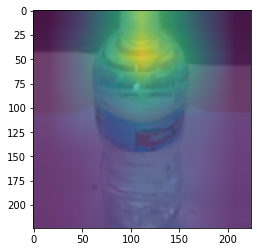

Generating Grad-CAM @layer4_c
46: water_bottle (94.74%)
	#Other Predictions
	Prediction #2: soda_can        [ 1.49%]
	Prediction #3: shampoo         [ 0.88%]
	Prediction #4: food_jar        [ 0.72%]


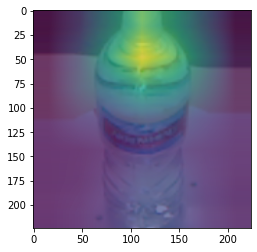

Generating Grad-CAM @layer4_c
45: toothpaste (85.41%)
	#Other Predictions
	Prediction #2: marker          [ 9.25%]
	Prediction #3: toothbrush      [ 1.33%]
	Prediction #4: dry_battery     [ 1.12%]


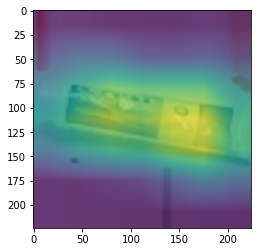

Generating Grad-CAM @layer4_c
41: soda_can (99.18%)
	#Other Predictions
	Prediction #2: food_can        [ 0.25%]
	Prediction #3: food_jar        [ 0.21%]
	Prediction #4: water_bottle    [ 0.11%]


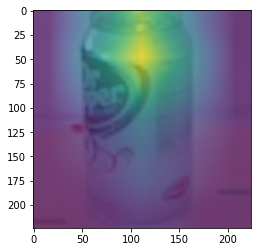

Generating Grad-CAM @layer4_c
44: toothbrush (96.98%)
	#Other Predictions
	Prediction #2: scissors        [ 1.63%]
	Prediction #3: toothpaste      [ 0.61%]
	Prediction #4: instant_noodles [ 0.35%]


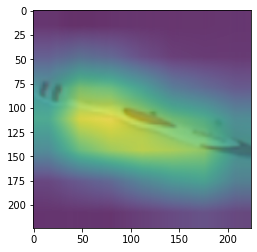

Generating Grad-CAM @layer4_c
25: keyboard (62.13%)
	#Other Predictions
	Prediction #2: calculator      [37.08%]
	Prediction #3: notebook        [ 0.13%]
	Prediction #4: scissors        [ 0.08%]


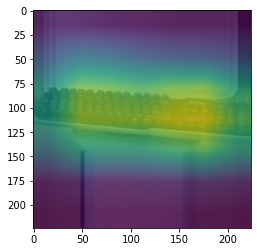

Generating Grad-CAM @layer4_c
15: food_bag (98.56%)
	#Other Predictions
	Prediction #2: hand_towel      [ 0.32%]
	Prediction #3: greens          [ 0.29%]
	Prediction #4: instant_noodles [ 0.12%]


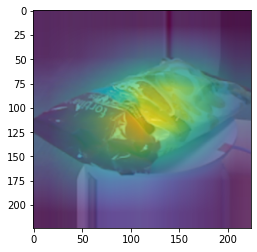

Generating Grad-CAM @layer4_c
9: cell_phone (94.98%)
	#Other Predictions
	Prediction #2: calculator      [ 1.45%]
	Prediction #3: camera          [ 1.00%]
	Prediction #4: stapler         [ 0.43%]


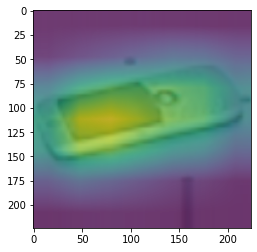

Generating Grad-CAM @layer4_c
14: flashlight (84.36%)
	#Other Predictions
	Prediction #2: marker          [ 3.89%]
	Prediction #3: hand_towel      [ 1.19%]
	Prediction #4: food_jar        [ 1.11%]


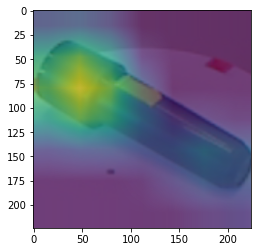

Generating Grad-CAM @layer4_c
39: scissors (75.44%)
	#Other Predictions
	Prediction #2: pliers          [10.71%]
	Prediction #3: toothbrush      [ 6.02%]
	Prediction #4: comb            [ 0.97%]


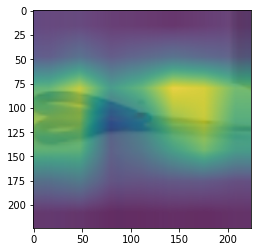

In [26]:
for rgb, depth in lista_immagini_giuste:
  image_r = pil_loader(rgb)
  image_d = pil_loader(depth)
  image_rgb = test_transform(image_r)           # prepare for net rgb
  image_depth = test_transform(image_d)         # prepare for net depth
  image_r = target_transform_no_norm(image_r)   # raw image
  image_d = target_transform_no_norm(image_d)   # raw depth
  image_r = image_r.squeeze(0).permute(1,2,0)   # reorder layers raw image (for display)  
  image_d = image_d.squeeze(0).permute(1,2,0)   # reorder layers raw image (for display)  
  
  image_rgb = image_rgb.to(DEVICE)
  image_depth = image_depth.to(DEVICE)
  # Get predictions
  gcam = GradCAM(model=net)
  probs, ids = gcam.forward(image = image_rgb.unsqueeze(0), depth = image_depth.unsqueeze(0))
  # ids: class id sorted by largest to smallest probability
  # probability of classes sorted
  other_3_label = [label_dict[int(ids[0][i+1])] for i in range(3)]
  other_3_probs = [float(probs[0][i+1])*100 for i in range(3)]
  lable_predicted = ids[0][0].item()
  class_predicted = label_dict[lable_predicted]
  proba_predicted = float(probs[0][0]) * 100
  proba_predicteds = f'{proba_predicted:.2f}'.replace('.','_')
  ids_ = torch.LongTensor([[ids[0][0]]]).to(DEVICE)
  gcam.backward(ids=ids_)
  print(f"Generating Grad-CAM @{target_layer}")

  # Grad-CAM
  regions = gcam.generate(target_layer=target_layer) #regions.shape = [1, 1, 224, 224] 

  print(f'{ids[0][0].item()}: {class_predicted} ({proba_predicted:.2f}%)')
  print('\t#Other Predictions')
  pos = 2
  for label, prob in zip(other_3_label,other_3_probs):
    print(f'\tPrediction #{pos}: {label:<15} [{prob:5.2f}%]')
    pos += 1
  immagine_cpu = regions[0,0,:,:].to('cpu') #immagine_cpu.shape = [224, 224] 
  
  plt.imshow(image_r)
  plt.imshow(immagine_cpu, alpha= .7)
  plt.show()
  show_cam_on_image(image_r, immagine_cpu, f'correct_{class_predicted}_{proba_predicteds}.png')
  show_raw_image(image_r, f'correct_{class_predicted}_{proba_predicteds}_raw.png')


###Wrong Predictions

Generating Grad-CAM @layer4_c
Predicted: 27 = lemon (74.64%)
	#Other Predictions
	Prediction #2: apple        [13.91%]
	Prediction #3: bell_papper  [ 3.20%]
	Prediction #4: orange       [ 2.48%]


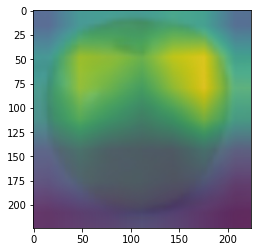

Generating Grad-CAM @layer4_c
Predicted: 27 = lemon (94.99%)
	#Other Predictions
	Prediction #2: orange       [ 1.92%]
	Prediction #3: apple        [ 0.96%]
	Prediction #4: pear         [ 0.74%]


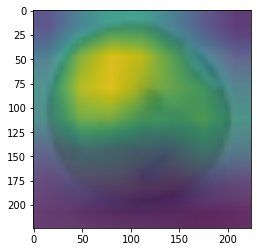

Generating Grad-CAM @layer4_c
Predicted: 28 = lightbulb (57.63%)
	#Other Predictions
	Prediction #2: garlic       [ 9.45%]
	Prediction #3: ball         [ 5.30%]
	Prediction #4: apple        [ 2.79%]


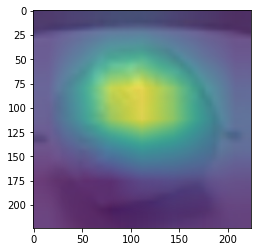

Generating Grad-CAM @layer4_c
Predicted: 41 = soda_can (99.78%)
	#Other Predictions
	Prediction #2: food_can     [ 0.05%]
	Prediction #3: shampoo      [ 0.04%]
	Prediction #4: glue_stick   [ 0.02%]


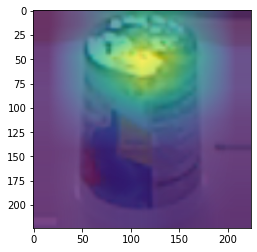

Generating Grad-CAM @layer4_c
Predicted: 40 = shampoo (98.24%)
	#Other Predictions
	Prediction #2: soda_can     [ 0.28%]
	Prediction #3: glue_stick   [ 0.27%]
	Prediction #4: water_bottle [ 0.13%]


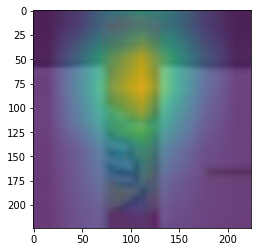

Generating Grad-CAM @layer4_c
Predicted: 6 = calculator (56.48%)
	#Other Predictions
	Prediction #2: keyboard     [41.56%]
	Prediction #3: food_bag     [ 0.41%]
	Prediction #4: hand_towel   [ 0.20%]


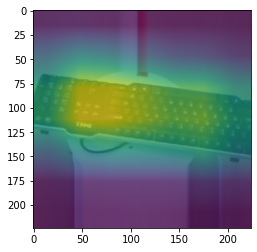

Generating Grad-CAM @layer4_c
Predicted: 11 = coffee_mug (48.18%)
	#Other Predictions
	Prediction #2: bowl         [45.46%]
	Prediction #3: plate        [ 2.06%]
	Prediction #4: instant_noodles [ 1.73%]


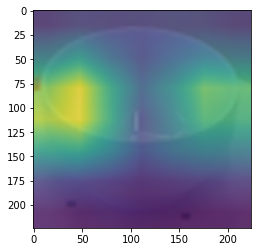

Generating Grad-CAM @layer4_c
Predicted: 11 = coffee_mug (54.01%)
	#Other Predictions
	Prediction #2: bowl         [42.66%]
	Prediction #3: instant_noodles [ 1.01%]
	Prediction #4: food_cup     [ 0.99%]


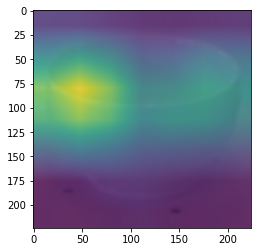

Generating Grad-CAM @layer4_c
Predicted: 41 = soda_can (98.31%)
	#Other Predictions
	Prediction #2: food_jar     [ 0.88%]
	Prediction #3: food_can     [ 0.12%]
	Prediction #4: water_bottle [ 0.07%]


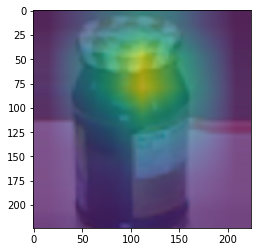

Generating Grad-CAM @layer4_c
Predicted: 15 = food_bag (72.51%)
	#Other Predictions
	Prediction #2: instant_noodles [21.59%]
	Prediction #3: toothpaste   [ 1.51%]
	Prediction #4: sponge       [ 0.63%]


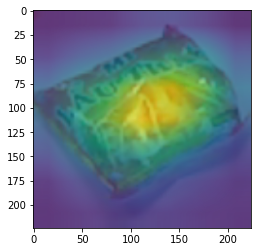

In [27]:
for rgb, depth in lista_immagini_sbagliate:
  image_r = pil_loader(rgb)
  image_d = pil_loader(depth)
  image_rgb = test_transform(image_r)           # prepare for net rgb
  image_depth = test_transform(image_d)         # prepare for net depth
  image_r = target_transform_no_norm(image_r)   # raw image
  image_d = target_transform_no_norm(image_d)   # raw depth
  image_r = image_r.squeeze(0).permute(1,2,0)   # reorder layers raw image (for display)  
  image_d = image_d.squeeze(0).permute(1,2,0)   # reorder layers raw image (for display)  
  
  label_expected = rgb.split('/')[2]
  
  image_rgb = image_rgb.to(DEVICE)
  image_depth = image_depth.to(DEVICE)
  # Get predictions
  gcam = GradCAM(model=net)
  probs, ids = gcam.forward(image = image_rgb.unsqueeze(0), depth = image_depth.unsqueeze(0))
  # ids: class id sorted by largest to smallest probability
  # probability of classes sorted
  other_3_label = [label_dict[int(ids[0][i+1])] for i in range(3)]
  other_3_probs = [float(probs[0][i+1])*100 for i in range(3)]
  lable_predicted = ids[0][0].item()
  class_predicted = label_dict[lable_predicted]
  proba_predicted = float(probs[0][0]) * 100
  proba_predicteds = f'{proba_predicted:.2f}'.replace('.','_')
  ids_ = torch.LongTensor([[ids[0][0]]]).to(DEVICE)
  gcam.backward(ids=ids_)
  print(f"Generating Grad-CAM @{target_layer}")

  # Grad-CAM
  regions = gcam.generate(target_layer=target_layer) #regions.shape = [1, 1, 224, 224] 

  print(f'Predicted: {lable_predicted} = {class_predicted} ({proba_predicted:.2f}%)')
  print('\t#Other Predictions')
  pos = 2
  for label, prob in zip(other_3_label,other_3_probs):
    print(f'\tPrediction #{pos}: {label:<12} [{prob:5.2f}%]')
    pos += 1
  immagine_cpu = regions[0,0,:,:].to('cpu') #immagine_cpu.shape = [224, 224]
  
  plt.imshow(image_r)
  plt.imshow(immagine_cpu, alpha= .7)
  plt.show()
  show_cam_on_image(image_r, immagine_cpu, f'wrong_{class_predicted}_{proba_predicteds}_correct_{label_expected}.png')
  show_raw_image(image_r, f'wrong_{class_predicted}_{proba_predicteds}_correct_{label_expected}_raw.png')

In [28]:
!zip correct.zip corre*

  adding: correct_cell_phone_94_98.png (deflated 8%)
  adding: correct_cell_phone_94_98_raw.png (deflated 22%)
  adding: correct_flashlight_84_36.png (deflated 8%)
  adding: correct_flashlight_84_36_raw.png (deflated 11%)
  adding: correct_food_bag_98_56.png (deflated 13%)
  adding: correct_food_bag_98_56_raw.png (deflated 30%)
  adding: correct_keyboard_62_13.png (deflated 16%)
  adding: correct_keyboard_62_13_raw.png (deflated 52%)
  adding: correct_scissors_75_44.png (deflated 14%)
  adding: correct_scissors_75_44_raw.png (deflated 48%)
  adding: correct_soda_can_99_18.png (deflated 7%)
  adding: correct_soda_can_99_18_raw.png (deflated 2%)
  adding: correct_toothbrush_96_98.png (deflated 13%)
  adding: correct_toothbrush_96_98_raw.png (deflated 37%)
  adding: correct_toothpaste_85_41.png (deflated 14%)
  adding: correct_toothpaste_85_41_raw.png (deflated 36%)
  adding: correct_water_bottle_94_74.png (deflated 10%)
  adding: correct_water_bottle_94_74_raw.png (deflated 1%)
  adding:

In [29]:
!zip wrong.zip wro*

  adding: wrong_calculator_56_48_correct_keyboard.png (deflated 12%)
  adding: wrong_calculator_56_48_correct_keyboard_raw.png (deflated 35%)
  adding: wrong_coffee_mug_48_18_correct_bowl.png (deflated 4%)
  adding: wrong_coffee_mug_48_18_correct_bowl_raw.png (deflated 2%)
  adding: wrong_coffee_mug_54_01_correct_bowl.png (deflated 8%)
  adding: wrong_coffee_mug_54_01_correct_bowl_raw.png (deflated 4%)
  adding: wrong_food_bag_72_51_correct_instant_noodles.png (deflated 2%)
  adding: wrong_food_bag_72_51_correct_instant_noodles_raw.png (deflated 2%)
  adding: wrong_lemon_74_64_correct_apple.png (deflated 4%)
  adding: wrong_lemon_74_64_correct_apple_raw.png (deflated 2%)
  adding: wrong_lemon_94_99_correct_pear.png (deflated 4%)
  adding: wrong_lemon_94_99_correct_pear_raw.png (deflated 2%)
  adding: wrong_lightbulb_57_63_correct_ball.png (deflated 5%)
  adding: wrong_lightbulb_57_63_correct_ball_raw.png (deflated 4%)
  adding: wrong_shampoo_98_24_correct_glue_stick.png (deflated 13%)
